In [ ]:
from IPython.display import display
import spot
from spot.jupyter import display_inline
spot.setup()
import copy

In [ ]:
## With DS based proposition wipeA
# x -> wet, y -> dirt
# a -> wipe: original dynamical system, b -> wipe dirt: STL, c -> dip: STL
a1 = spot.formula('G ((!a & !b & c) | (!a & b & !c) | (a & !b & !c)) & G(!x -> F c) & G((x & !y) -> X a) & G((x & y) -> F b)');
a1

spot.formula("G((!a & !b & c) | (!a & b & !c) | (a & !b & !c)) & G(!x -> Fc) & G((x & !y) -> Xa) & G((x & y) -> Fb)")

In [ ]:
## Sequential tasks?
# x -> wet, y -> dirt
# a -> wipe: original dynamical system, b -> wipe dirt: STL, c -> dip: STL
a1 = spot.formula('G ((!a & !b & c) | (!a & b & !c) | (a & !b & !c)) & G(!x -> X a -> F c) & G((x & !y) -> X a) & G((x & y) -> F b)');
a1

spot.formula("G((!a & !b & c) | (!a & b & !c) | (a & !b & !c)) & G(!x -> (Xa -> Fc)) & G((x & !y) -> Xa) & G((x & y) -> Fb)")

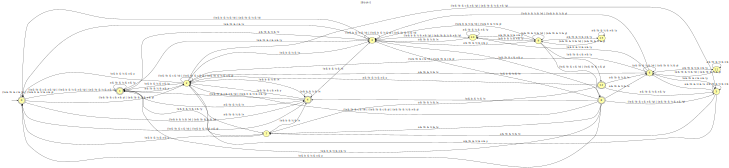

In [ ]:
a1_aut = spot.translate(a1, 'ba', 'small', 'high', 'StateBasedAcceptance')
a1_aut

In [ ]:
import spot

def custom_print(aut):
    bdict = aut.get_dict()
    print("Acceptance:", aut.get_acceptance())
    print("Number of sets:", aut.num_sets())
    print("Number of states: ", aut.num_states())
    print("Initial states: ", aut.get_init_state_number())
    print("Atomic propositions:", end='')
    for ap in aut.ap():
        print(' ', ap, ' (=', bdict.varnum(ap), ')', sep='', end='')
    print()
    # Templated methods are not available in Python, so we cannot
    # retrieve/attach arbitrary objects from/to the automaton.  However the
    # Python bindings have get_name() and set_name() to access the
    # "automaton-name" property.
    name = aut.get_name()
    if name:
        print("Name: ", name)
    print("Deterministic:", aut.prop_universal() and aut.is_existential())
    print("Unambiguous:", aut.prop_unambiguous())
    print("State-Based Acc:", aut.prop_state_acc())
    print("Terminal:", aut.prop_terminal())
    print("Weak:", aut.prop_weak())
    print("Inherently Weak:", aut.prop_inherently_weak())
    print("Stutter Invariant:", aut.prop_stutter_invariant())

    for s in range(0, aut.num_states()):
        print("State {}:".format(s))
        for t in aut.out(s):
            print("  edge({} -> {})".format(t.src, t.dst))
            # bdd_print_formula() is designed to print on a std::ostream, and
            # is inconvenient to use in Python.  Instead we use
            # bdd_format_formula() as this simply returns a string.
            print("    label =", spot.bdd_format_formula(bdict, t.cond))
            print("    acc sets =", t.acc)

custom_print(a1_aut)

Acceptance: Inf(0)
Number of sets: 1
Number of states:  14
Initial states:  0
Atomic propositions: a (=0) b (=1) c (=2) x (=3) y (=4)
Deterministic: maybe
Unambiguous: maybe
State-Based Acc: yes
Terminal: no
Weak: maybe
Inherently Weak: maybe
Stutter Invariant: maybe
State 0:
  edge(0 -> 0)
    label = (!a & !b & c & !x) | (!a & b & !c & x & y)
    acc sets = {0}
  edge(0 -> 1)
    label = (!a & !b & c & x & !y) | (!a & b & !c & x & !y) | (a & !b & !c & x & !y)
    acc sets = {0}
  edge(0 -> 2)
    label = (!a & !b & c & x & y) | (a & !b & !c & x & y)
    acc sets = {0}
  edge(0 -> 3)
    label = (!a & b & !c & !x) | (a & !b & !c & !x)
    acc sets = {0}
  edge(0 -> 4)
    label = (!a & b & !c & !x) | (a & !b & !c & !x)
    acc sets = {0}
State 1:
  edge(1 -> 1)
    label = a & !b & !c & x & !y
    acc sets = {0}
  edge(1 -> 2)
    label = a & !b & !c & x & y
    acc sets = {0}
  edge(1 -> 3)
    label = a & !b & !c & !x
    acc sets = {0}
  edge(1 -> 4)
    label = a & !b & !c & !x
  

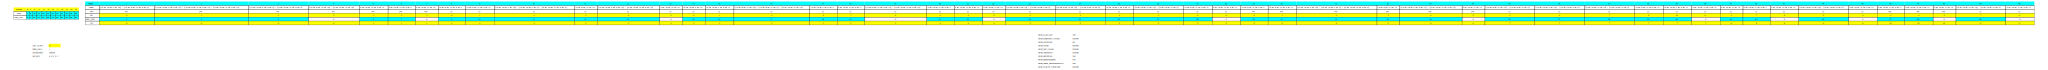

In [ ]:
a1_aut.show_storage()

In [ ]:
import spot

class Node:

    def __init__(self, vertexNumber, is_acc):
        self.vertexNumber = vertexNumber
        self.is_acc = is_acc
        self.out = []

class Edge:

    def __init__(self, EdgeNumber, src, dst, cond):
        self.EdgeNumber = EdgeNumber
        self.src = src
        self.dst = dst
        self.cond = cond

        cond_control_APs=[]
        for i in range(len(cond)):
            cond_control = cond[i][0]
            cond_control_APs_i= []
            j = 0
            while(j<len(cond_control)):
                if cond_control[j]=='(':
                    cond_control_APs_i.append(0)
                    j += 12
                else:
                    cond_control_APs_i.append(1)
                    j += 4
            cond_control_APs.append(cond_control_APs_i)
        self.cond_control_APs = cond_control_APs

class Graph:

    def __init__(self, nodes, edges, APs, n_cont_AP, n_uncont_AP):
        self.nodes = nodes
        self.edges = edges
        self.APs = APs
        self.n_cont_AP = n_cont_AP
        self.n_uncont_AP = n_uncont_AP


    def trans(self, node_index, label):
        control_APs = label[0]
        uncontrol_APs = label[1]
        ## symbols for APs -> eval() method depends on this
        a = control_APs[0]
        b = control_APs[1]
        c = control_APs[2]

        x = uncontrol_APs[0]
        y = uncontrol_APs[1]

        for i in self.nodes[node_index].out:
            for j in i.cond:
                if eval(j[0]) & eval(j[1]):
                    return i.dst
        return 'invalid'

    def get_edge(self, start_node, dest_node):
        for i in start_node.out:
            if i.dst == dest_node.vertexNumber:
                return i
        return None

def bdd_cond_to_list(cond):
        cond_check_all = []
        cond_check_mod = []
        cond_check_cont_uncont = []
        i = 0
        and_c = 0
        or_flag = 0
        while(i < len(cond)):
            if cond[i]=='!':
                ap_n = cond[i+1]
                cond_check_mod.append('(')
                cond_check_mod.append('not')
                cond_check_mod.append(ap_n)
                cond_check_mod.append(')')
                i += 2
            elif cond[i]=='(' and (not cond_check_mod):
                i += 1
            elif cond[i]==' ':
                i += 1
            # each subformula that are connected by a disjunction are separate elements of a list
            elif cond[i]=='|':
                or_flag = 1
                i += 1
                and_c = 0
                cond_check_mod.pop()
                cond_check_uncontrol = ' '.join(cond_check_mod)
                cond_check_cont_uncont.append(cond_check_uncontrol)
                cond_check_all.append(cond_check_cont_uncont)
                cond_check_mod = []
                cond_check_cont_uncont = []
            elif cond[i]=='&':
                and_c += 1
                if and_c == 3:
                    and_c = 0
                    cond_check_string_control = ' '.join(cond_check_mod)
                    cond_check_cont_uncont.append(cond_check_string_control)
                    cond_check_mod = []
                else:
                    cond_check_mod.append(cond[i])
                i += 1
            else:
                cond_check_mod.append(cond[i])
                i += 1

        if or_flag == 1:
            cond_check_mod.pop()
        cond_check_uncontrol = ' '.join(cond_check_mod)
        cond_check_cont_uncont.append(cond_check_uncontrol)
        cond_check_all.append(cond_check_cont_uncont)

        return cond_check_all

def graph_construct(aut):
    bdict = aut.get_dict()

    APs = sorted([str(p) for p in aut.ap()])

    Nodes = []
    Edges = []

    for s in range(0, aut.num_states()):
        node_s = Node(s, aut.state_is_accepting(s))
        Nodes.append(node_s)
    for ne in range(0, aut.num_edges()):
        t = a1_aut.edge_storage(ne+1)
        bdd = spot.bdd_format_formula(bdict, t.cond)
        cond_list = bdd_cond_to_list(bdd)
        edge_ne = Edge(ne, t.src, t.dst, cond_list)
        Edges.append(edge_ne)
        Nodes[t.src].out.append(edge_ne)

    graph = Graph(Nodes, Edges, APs, 3, 2)

    return graph

In [ ]:
control_AP = [1, 0, 0]
uncontrol_AP = [1, 0]
label = [control_AP[:], uncontrol_AP[:]]
label[1]

[1, 0]

In [ ]:
a1_graph = graph_construct(a1_aut)

In [ ]:
a1_graph

In [ ]:
len(a1_graph.nodes)

import pickle

with open('aut_graph.dictionary', 'wb') as aut_graph_dictionary_file:

  pickle.dump(a1_graph, aut_graph_dictionary_file)

In [ ]:
with open('aut_graph.dictionary', 'rb') as aut_graph_dictionary_file:
    aut_graph_load = pickle.load(aut_graph_dictionary_file)
    print(aut_graph_load)

aut_graph_load.edges[0].cond

[['( not a ) & ( not b ) & c', '( not x )'],
 ['( not a ) & b & ( not c )', 'x & y']]

In [ ]:
def mod_graph(aut_graph, uncontrol_AP):
    ## symbols for uncontrollable propositions
    x = uncontrol_AP[0]
    y = uncontrol_AP[1]

    mod_aut_graph = copy.deepcopy(aut_graph)
    remove_count = 0
    for i in range(len(aut_graph.edges)):
        j = 0
        remove_flag = 1
        # Number of subformula combined with 'or' in the label of the transition
        while j<(len(aut_graph.edges[i].cond)):
            if eval(aut_graph.edges[i].cond[j][1]):
                j = len(aut_graph.edges[i].cond)
                remove_flag = 0
            else:
                j += 1
        if remove_flag:
            remove_ind = i - remove_count # index in the list of edges
            edge_to_be_removed = mod_aut_graph.edges[remove_ind]
            source_node_index = edge_to_be_removed.src
            mod_aut_graph.nodes[source_node_index].out.remove(edge_to_be_removed) # remove edge from source node
            mod_aut_graph.edges.remove(edge_to_be_removed) # remove edge from graph
            remove_count += 1
    return mod_aut_graph

In [ ]:
uncontrol_AP = [0, 1]
mod_aut_graph = mod_graph(a1_graph, uncontrol_AP)

# Should get the goal nodes again for the new modified graph
goal_nodes = [i for i in mod_aut_graph.nodes if i.is_acc]

In [ ]:
def shortest_path(aut_graph, start_node, goal_nodes):
    explored = []

    # Queue for traversing the
    # graph in the BFS
    queue = [[start_node]]

    # If the desired node is
    # reached
    if start_node.is_acc & (start_node.vertexNumber in [i.dst for i in start_node.out]):
        path = [start_node, start_node]
        path_edges = [aut_graph.get_edge(start_node, start_node)]
        return path, path_edges

    # Loop to traverse the graph
    # with the help of the queue
    while queue:
        path = queue.pop(0)
        node = path[-1]
        print(node.vertexNumber)

        # Condition to check if the
        # current node is not visited
        if node not in explored:
            neighbours = [aut_graph.nodes[i.dst] for i in node.out]

            # Loop to iterate over the
            # neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)

                # Condition to check if the
                # neighbour node is the goal
                if neighbour in goal_nodes:
                    path_edges = []
                    # Reading out the edges of the path
                    for i in range(len(new_path)-1):
                        path_edges.append(aut_graph.get_edge(new_path[i], new_path[i+1]))
                    return new_path, path_edges
            explored.append(node)

    # Condition when the nodes
    # are not connected
    return None

def get_curr_control_prop(curr_edge, uncontrol_AP):
    x = uncontrol_AP[0]
    y = uncontrol_AP[1]
    for i in range(len(curr_edge.cond)):
        if eval(curr_edge.cond[i][1]):
            return int(np.nonzero(curr_edge.cond_control_APs[i])[0])

    return None

In [ ]:
[0, 0, 1] == [0, 0, 1]

True

In [ ]:
import numpy as np
path, path_edges = shortest_path(mod_aut_graph, mod_aut_graph.nodes[0], goal_nodes)
print('Path:', [i.vertexNumber for i in path])
print('Edges in the path:', [i.cond for i in path_edges])
curr_edge = path_edges[0]
print('controllable proposition:', get_curr_control_prop(curr_edge, uncontrol_AP))

Path: [0, 0]
Edges in the path: [[['( not a ) & ( not b ) & c', '( not x )'], ['( not a ) & b & ( not c )', 'x & y']]]
controllable proposition: 2


In [ ]:
mod_aut_graph.edges[0].cond_control_APs

[[0, 0, 1], [0, 1, 0]]

In [ ]:
[i.dst for i in start_node.out]

[1, 4]

In [ ]:
for i in mod_aut_graph.edges:
    print(i.EdgeNumber, i.cond)
    print('\n')

0 [['( not a ) & ( not b ) & c', '( not x )'], ['( not a ) & b & ( not c )', 'x & y']]


3 [['( not a ) & b & ( not c )', '( not x )'], ['a & ( not b ) & ( not c )', '( not x )']]


6 [['a & ( not b ) & ( not c )', '( not x )']]


9 [['( not a ) & ( not b ) & c', '( not x )'], ['( not a ) & ( not b ) & c', 'y'], ['a & ( not b ) & ( not c )', 'x & y']]


10 [['( not a ) & b & ( not c )', '( not x )']]


12 [['a & ( not b ) & ( not c )', '( not x )']]


13 [['( not a ) & ( not b ) & c', '( not x )']]


15 [['( not a ) & b & ( not c )', '( not x )'], ['( not a ) & b & ( not c )', 'y'], ['a & ( not b ) & ( not c )', '( not x )']]


21 [['a & ( not b ) & ( not c )', '( not x )']]


22 [['( not a ) & ( not b ) & c', '( not x )'], ['( not a ) & ( not b ) & c', 'y']]


23 [['( not a ) & b & ( not c )', '( not x )'], ['( not a ) & b & ( not c )', 'y']]


25 [['a & ( not b ) & ( not c )', '( not x )'], ['a & ( not b ) & ( not c )', 'y']]


30 [['( not a ) & ( not b ) & c', '( not x )'], ['( not 